In [44]:
import pandas as pd
import numpy as np
import datetime
import yfinance as yf
import yaml
import scipy.optimize as optimize
import matplotlib.pyplot as plt

In [29]:
with open("config.yaml", "r") as f:
    config = yaml.safe_load(f)

asssets = ['NVDA',  'MSFT', 'AMZN']
num_assets = len(asssets)

## 1. Conseguir la base de datos

In [9]:
def get_data(ticker:str,price:str):
    """
    Obtener los precios historicos  de una accion
    |Var   |type| Example|
    |-----|-----|--------| 
    |ticker|str | 'NVDA',  'MSFT', 'AMZN', 'AAPL'|
    |price |str | ['Open'	'High'	'Low	Close'	'Adj Close']|

    A continuacion se describen las opciones sobre el precio de las acciones

    * Open: El precio de apertura de las acciones en ese día.
    * High: El precio más alto alcanzado por las acciones durante el día.
    * Low: El precio más bajo alcanzado por las acciones durante el día.
    * Close: El precio de cierre de las acciones en ese día.
    * Adj Close: El precio de cierre ajustado, que tiene en cuenta eventos como dividendos, divisiones de acciones, etc. Es considerado como el precio real de cierre.

    La salida consiste en un DataFrame que nos sera util para formar una base de datos sobre los precios historicos.
    """
    data = yf.download(ticker)[price]
    return data


In [10]:
def get_DB(tickers:list, price:str, save=False):
    data =  pd.DataFrame()
    for ticker in tickers:
        print(ticker)
        data[ticker] = get_data(ticker=ticker, price=price)
    if save:
        print(f'Archivo guardado: data{price.replace(" ", "")}.csv')
        data.to_csv(f'data{price.replace(" ", "")}.csv')
    return data

In [11]:
data = get_DB(tickers=config['Empresas'], price=config['price'],save=True)

AAPL


[*********************100%%**********************]  1 of 1 completed


MSFT


[*********************100%%**********************]  1 of 1 completed


AMZN


[*********************100%%**********************]  1 of 1 completed


GOOGL


[*********************100%%**********************]  1 of 1 completed


TSLA


[*********************100%%**********************]  1 of 1 completed


BABA


[*********************100%%**********************]  1 of 1 completed


JNJ


[*********************100%%**********************]  1 of 1 completed


JPM


[*********************100%%**********************]  1 of 1 completed


V


[*********************100%%**********************]  1 of 1 completed


PG


[*********************100%%**********************]  1 of 1 completed


KO


[*********************100%%**********************]  1 of 1 completed


INTC


[*********************100%%**********************]  1 of 1 completed


GS


[*********************100%%**********************]  1 of 1 completed


XOM


[*********************100%%**********************]  1 of 1 completed


VZ


[*********************100%%**********************]  1 of 1 completed


BA


[*********************100%%**********************]  1 of 1 completed


DIS


[*********************100%%**********************]  1 of 1 completed


PFE


[*********************100%%**********************]  1 of 1 completed


CSCO


[*********************100%%**********************]  1 of 1 completed


IBM


[*********************100%%**********************]  1 of 1 completed


GE


[*********************100%%**********************]  1 of 1 completed


ORCL


[*********************100%%**********************]  1 of 1 completed


CVX


[*********************100%%**********************]  1 of 1 completed


PEP


[*********************100%%**********************]  1 of 1 completed


WMT


[*********************100%%**********************]  1 of 1 completed


MMM


[*********************100%%**********************]  1 of 1 completed


ADBE


[*********************100%%**********************]  1 of 1 completed


MA


[*********************100%%**********************]  1 of 1 completed


MCD


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


GM
HD


[*********************100%%**********************]  1 of 1 completed


NFLX


[*********************100%%**********************]  1 of 1 completed


NVDA


[*********************100%%**********************]  1 of 1 completed


BAC


[*********************100%%**********************]  1 of 1 completed


HON


[*********************100%%**********************]  1 of 1 completed


CAT


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


PYPL
T


[*********************100%%**********************]  1 of 1 completed


ACN


[*********************100%%**********************]  1 of 1 completed


Archivo guardado: dataAdjClose.csv


## 2. Manual Portfolio Selection

In [35]:

def FilterPortfolio(data, asssets:list):
    """
    Input: list of asserts, 

    return: port_returns and port volatility
    """
    df =data[asssets]
    df1 = df.copy()
    data = df1.dropna()

    log_returns = np.log(1+data.pct_change())

    port_returns = []
    port_volts = []


    for i in range(1000):
        num_assets = len(asssets)
        weigths = np.random.random(num_assets)
        weigths /= np.sum(weigths)
        port_returns.append(np.sum(weigths*log_returns.mean())*252)
        port_volts.append(np.sqrt(np.dot(weigths.T, np.dot(log_returns.cov()*252, weigths))))

    port_returns = np.array(port_returns)
    port_volts = np.array(port_volts)

    return log_returns, port_returns, port_volts


In [36]:
log_returns, port_returns, port_volts = FilterPortfolio(data=data, asssets=asssets)

In [38]:
def portfolio_stats(weigths, log_returns):
    port_returns = np.sum(weigths*log_returns.mean())*252
    port_volts   = np.sqrt(np.dot(weigths.T, np.dot(log_returns.cov()*252, weigths))) #252 por la media anualizada

    sharpe =  port_returns/port_volts
    return {'Return': port_returns, 'Volatility': port_volts, 'Sharpe': sharpe}



In [28]:
sharpe = port_returns/port_volts
max_sr_returns = port_returns[sharpe.argmax()]
max_sr_volatility = port_volts[sharpe.argmax()]

## Optimization

In [46]:
def minimize_sharpe(weigths, log_returns):
    return - portfolio_stats(weigths=weigths, log_returns=log_returns)['Sharpe']



In [47]:
def OptimalPortafolio():
    initializer = num_assets*[1./num_assets,]
    bounds = tuple((0,1) for x in range(num_assets))

    optimar_sharpe = optimize.minimize(minimize_sharpe, initializer, method='SLSQP', args=(log_returns,), bounds=bounds)
    optimar_sharpe_weights = optimar_sharpe['x'].round(3)
    print(f'Los pesos optimos en la cartera son: {list(zip(asssets, list(optimar_sharpe_weights*100)))}')
    optimal_stats  = portfolio_stats(optimar_sharpe_weights, log_returns=log_returns)
    optimal_return = np.round(optimal_stats['Return']*100,3)
    
    optimal_volatility = np.round(optimal_stats['Volatility']*100,3)
    optimal_sharpe = np.round(optimal_stats['Sharpe'],3)
    print(f'Retorno optimo de la cartera: {optimal_return}')
    print(f'Volatilidad optimo de la cartera: {optimal_volatility}')
    print(f'Sharpe optimo de la cartera: {optimal_sharpe}')

In [42]:
OptimalPortafolio()

[0.3333333333333333, 0.3333333333333333, 0.3333333333333333] ((0, 1), (0, 1), (0, 1))
Los pesos optimos en la cartera son: [('NVDA', 50.4), ('MSFT', 29.799999999999997), ('AMZN', 16.6)]
Retorno optimo de la cartera: 21.38
Volatilidad optimo de la cartera: 39.645
Sharpe optimo de la cartera: 0.539


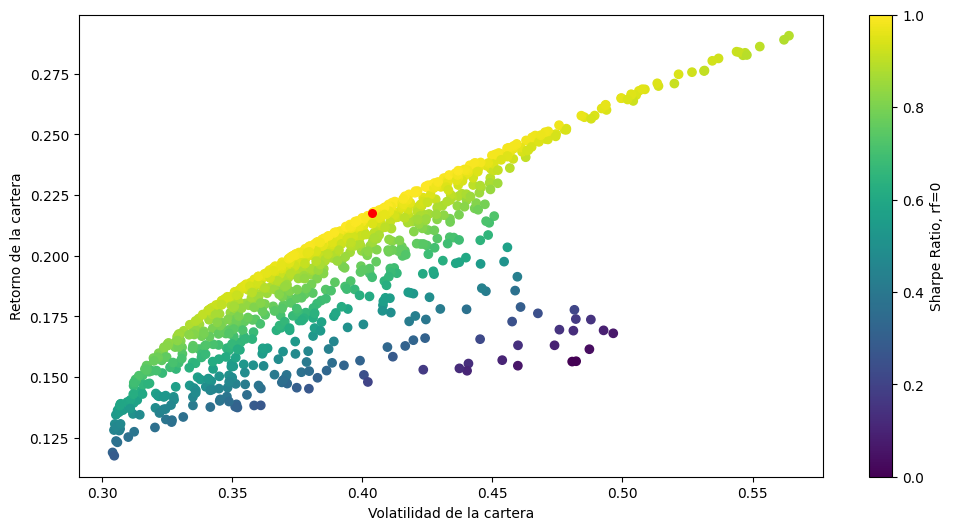

In [45]:
plt.figure(figsize=(12,6))
plt.scatter(port_volts, port_returns, c= (port_returns/port_volts))
plt.scatter(max_sr_volatility,max_sr_returns, c= 'red', s=30)
plt.colorbar(label = 'Sharpe Ratio, rf=0')
plt.xlabel('Volatilidad de la cartera')
plt.ylabel('Retorno de la cartera')
plt.show()